In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import random

The following code is adapted from https://github.com/gheisenberg/AML.

### Create the possible states

Each location name as a string, is encoded as a numeric value. There are 9 different states.

In [2]:
location_to_state = {
    'L0' : 0,
    'L1' : 1,
    'L2' : 2,
    'L3' : 3,
    'L4' : 4,
    'L5' : 5,
    'L6' : 6,
    'L7' : 7,
    'L8' : 8
}

state_to_location = dict((state,location) for location, state in location_to_state.items())

In [3]:
state_to_location

{0: 'L0',
 1: 'L1',
 2: 'L2',
 3: 'L3',
 4: 'L4',
 5: 'L5',
 6: 'L6',
 7: 'L7',
 8: 'L8'}

### Create the actions & rewards

There are 9 different actions that can be taken, simply corresponding to jumping to that particular state.

The rewards array represents a Markov chain like structure, where **a reward is given for particular state/action combinations, and not simply for moving to particular states.**

In [4]:
actions = [0,1,2,3,4,5,6,7,8]

In [5]:
rewards = np.array([[0,1,0,0,0,0,0,0,0],
                   [1,0,1,0,1,0,0,0,0],
                   [0,1,0,0,0,1,0,0,0],
                   [0,0,0,0,0,0,1,0,0],
                   [0,1,0,0,0,0,0,1,0],
                   [0,0,1,0,0,0,0,0,0],
                   [0,0,0,1,0,0,0,1,0],
                   [0,0,0,0,1,0,1,0,1],
                   [0,0,0,0,0,0,0,1,0]])

e.g. the agent gets a reward of 1, if it takes action 0 at state L2, or if it takes action 3 at state L7.

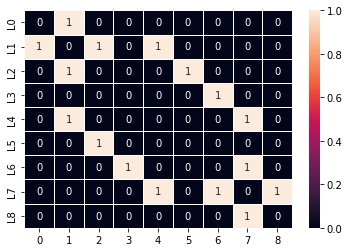

In [6]:
sns.heatmap(pd.DataFrame(rewards, index=location_to_state.keys()), annot=True, linewidth=0.5);

### Define the remaining hyperparameters

The discount factor for the return is gamma.  
The learning rate, for updating the q values in the q table, is alpha.

In [7]:
# initialize the parameters
gamma = 0.75 # discount factor
alpha = 0.9  # learning rate

### Define agent and its attributes

### Modified the agent to add an exploration rate:

In [55]:
class QAgent():
    # initialize everything
    def __init__(self, alpha, gamma, location_to_state, actions, rewards, state_to_location,
                exploration_rate, max_exploration_rate, min_exploration_rate, exploration_decay_rate):
        self.gamma = gamma
        self.alpha = alpha
        
        self.location_to_state = location_to_state
        self.actions = actions
        self.rewards = rewards
        self.state_to_location = state_to_location
        self.exploration_rate = exploration_rate
        self.max_exploration_rate = max_exploration_rate 
        self.min_exploration_rate = min_exploration_rate
        self.exploration_decay_rate = exploration_decay_rate
        
        # remember, the Q-value table is of size all actions x all states
        M = len(location_to_state)
        self.Q = np.zeros((M,M), dtype = None, order = 'C')
        
    # now, implement the training method for the agent
    def training(self, start_location, end_location, iterations):

        rewards_new = np.copy(self.rewards)

        ending_state = self.location_to_state[end_location]
        
        # recreate the rewards table, so the beginning and ending state/action pair is marked
        rewards_new[ending_state, ending_state] = 999
        print(rewards_new)
        sns.heatmap(pd.DataFrame(rewards_new, index=location_to_state.keys()), annot=True, linewidth=0.5, linecolor="black", norm=LogNorm());
        plt.show()

        # pick random current state
        # iterations = the # of training cycles
        for i in range(iterations):
            # this is the current state
            current_state = np.random.randint(0,9)
            playable_actions = []
            # iterate thru the rewards matrix to get states
            # that are really reachable from the randomly chosen
            # state and assign only those in a list since they are really playable
            for j in range(9):
            # given the current state, the only action the agent can take is ones that produce rewards
            # there may be more than one actions that produce a reward
                if rewards_new[current_state, j] > 0:
                    playable_actions.append(j)
            # choosing next random state
            # however, make sure that playable_actions is not empty
            if len(playable_actions) != 0:
                # Randomly select a value from playable_actions, e.g. randomly select an action
                # this action moves the agent to another column
                exploration_rate_threshold = random.uniform(0, 1)
                if exploration_rate_threshold > self.exploration_rate:
                    temp_q = np.copy(self.Q)
                    for non_playable in list(set(actions) - set(playable_actions)):
                        temp_q[current_state, non_playable] = -999
                    next_state = np.argmax(temp_q[current_state,:]) 
                else:
                    next_state = np.random.choice(playable_actions)
            # the action that the agent takes, also moves it to the state with the same number
            # finding the difference in Q, often referred to as temporal difference
            # by means of the Bellman's equation
            TD = rewards_new[current_state, next_state] + self.gamma * self.Q[next_state, np.argmax(self.Q[next_state,])] - self.Q[current_state, next_state]
            # combine with the learning rate
            self.Q[current_state, next_state] += self.alpha*TD
            # DEBUG
            #print(f"Q[{current_state}, {next_state}]:", self.Q[current_state, next_state])
            self.exploration_rate = self.min_exploration_rate + (self.max_exploration_rate - self.min_exploration_rate) * np.exp(-self.exploration_decay_rate*i)

        route = [start_location]
        next_location = start_location
        
        print('Q-table:')
        display(pd.DataFrame(self.Q, index=self.location_to_state.keys()))
        
        # print the optimal route from start to end
        self.get_optimal_route(start_location, end_location, next_location, route, self.Q)

    # compute the optimal route
    def get_optimal_route(self, start_location, end_location, next_location, route, Q):
        i = 0
        while i < 20 and (next_location != end_location):
            starting_state = self.location_to_state[start_location]
            next_state = np.argmax(Q[starting_state,:])
            next_location = self.state_to_location[next_state]
            route.append((np.argmax(Q[starting_state,:]), next_location))
            start_location = next_location
            i+=1
        # DEBUG
        print("optimal route:", route)

With no exploitation, only exploring, (decay rate of 0) it can learn the optimal path, by exploring all of the possibilities:

[[999   1   0   0   0   0   0   0   0]
 [  1   0   1   0   1   0   0   0   0]
 [  0   1   0   0   0   1   0   0   0]
 [  0   0   0   0   0   0   1   0   0]
 [  0   1   0   0   0   0   0   1   0]
 [  0   0   1   0   0   0   0   0   0]
 [  0   0   0   1   0   0   0   1   0]
 [  0   0   0   0   1   0   1   0   1]
 [  0   0   0   0   0   0   0   1   0]]


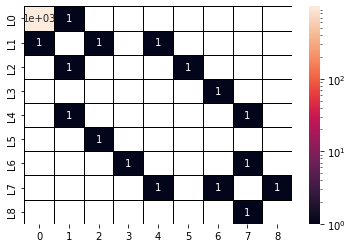

Q-table:


,0,1,2,3,4,5,6,7,8
L0,3995.998042,2249.498313,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
L1,2997.998091,0.000000,1688.118603,0.000000,1688.118556,0.000000,0.000000,0.000000,0.000000
L2,0.000000,2249.491471,0.000000,0.000000,0.000000,1267.088941,0.000000,0.000000,0.000000
L3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,951.316489,0.000000,0.000000
L4,0.000000,2249.491471,0.000000,0.000000,0.000000,0.000000,0.000000,1267.088847,0.000000
L5,0.000000,0.000000,1688.118603,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
L6,0.000000,0.000000,0.000000,714.480345,0.000000,0.000000,0.000000,1267.088745,0.000000
L7,0.000000,0.000000,0.000000,0.000000,1688.118465,0.000000,951.316402,0.000000,951.316486
L8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1267.088840,0.000000


optimal route: ['L8', (7, 'L7'), (4, 'L4'), (1, 'L1'), (0, 'L0')]


In [68]:
exploration_rate = 1
max_exploration_rate = 1
min_exploration_rate = 0.01
exploration_decay_rate = 0
gamma = 0.75 # discount factor
alpha = 0.9  # learning rate
qagent = QAgent(alpha, gamma, location_to_state, actions, rewards, state_to_location, exploration_rate, max_exploration_rate, min_exploration_rate, exploration_decay_rate)
qagent.training(start_location='L8', end_location='L0', iterations=1000)

**If the agent starts exploiting too early, and it never learns how to reach the highest 999 reward in the top left**, it gets stuck in a local minimum, of just picking up +1 rewards, by alternating from moving to state 8 and state 7!

[[999   1   0   0   0   0   0   0   0]
 [  1   0   1   0   1   0   0   0   0]
 [  0   1   0   0   0   1   0   0   0]
 [  0   0   0   0   0   0   1   0   0]
 [  0   1   0   0   0   0   0   1   0]
 [  0   0   1   0   0   0   0   0   0]
 [  0   0   0   1   0   0   0   1   0]
 [  0   0   0   0   1   0   1   0   1]
 [  0   0   0   0   0   0   0   1   0]]


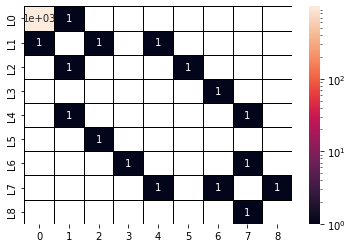

Q-table:


,0,1,2,3,4,5,6,7,8
L0,0.000000,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
L1,3.599999,0.000000,4.0,0.0,0.9,0.0,0.0,0.0,0.0
L2,0.000000,1.673325,0.0,0.0,0.0,4.0,0.0,0.0,0.0
L3,0.000000,0.000000,0.0,0.0,0.0,0.0,4.0,0.0,0.0
L4,0.000000,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
L5,0.000000,0.000000,4.0,0.0,0.0,0.0,0.0,0.0,0.0
L6,0.000000,0.000000,0.0,4.0,0.0,0.0,0.0,0.0,0.0
L7,0.000000,0.000000,0.0,0.0,0.0,0.0,0.9,0.0,4.0
L8,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,4.0,0.0


optimal route: ['L8', (7, 'L7'), (8, 'L8'), (7, 'L7'), (8, 'L8'), (7, 'L7'), (8, 'L8'), (7, 'L7'), (8, 'L8'), (7, 'L7'), (8, 'L8'), (7, 'L7'), (8, 'L8'), (7, 'L7'), (8, 'L8'), (7, 'L7'), (8, 'L8'), (7, 'L7'), (8, 'L8'), (7, 'L7'), (8, 'L8')]


In [60]:
exploration_rate = 1
max_exploration_rate = 0.7 # LOW STARTING EXPLORATION RATE
min_exploration_rate = 0.01
exploration_decay_rate = 0.1 # HIGH DECAY RATE OF 0.1
gamma = 0.75 # discount factor
alpha = 0.9  # learning rate
qagent = QAgent(alpha, gamma, location_to_state, actions, rewards, state_to_location, exploration_rate, max_exploration_rate, min_exploration_rate, exploration_decay_rate)
qagent.training(start_location='L8', end_location='L0', iterations=1000)